# Facial Expression Recognition (FER)

This project is the Capstone project for the ML-bookcamp (with Alexey Grigorev).

The dataset come from an old Kaggle competition:
- Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

The tried CCN architectures come from variours sources (either papers or githibs):

- CNN architecture 1: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras
- CNN architecture 2: https://github.com/gitshanks/fer2013
- CNN architecture 3: https://github.com/amirhossein-hkh/facial-expression-recognition

**Note**: I used these architectures and obviously read some parts of these resources, but I tried to work by myself as much as possible.

Also, I asked Alexey about "Cheating and plagiarism" regarding the CNN architectures from these source here:
- https://datatalks-club.slack.com/archives/C0288NJ5XSA/p1638880791240000


---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

#### Seed for reproductibility

Does't seem very useful

In [2]:
np.random.seed(1)
tf.random.set_seed(2)

# 1. Load & explore data <a class="anchor" id="P01"></a>

In [3]:
data = pd.read_csv('data/fer2013.csv')

In [4]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### Rename the columns <a class="anchor" id="P0_rename_columns"></a>

In [5]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

> This is not very useful in this project, but it's a good habit...

### Check the columns names & types <a class="anchor" id="P0_check_types"></a>

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


> The `target` values are int64
>
> **/!\** The `input` feature is an object and hence it needs to be converted / processed

#### Convert `pixels` input `strings` to `arrays`
/!\ The process takes a lot of ressources, it may slow down your computer.

In [7]:
img_array = data['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [9]:
le = LabelEncoder()
img_labels = le.fit_transform(data['emotion'])
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

#### Display some images

In [10]:
emotion_names = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral',
}

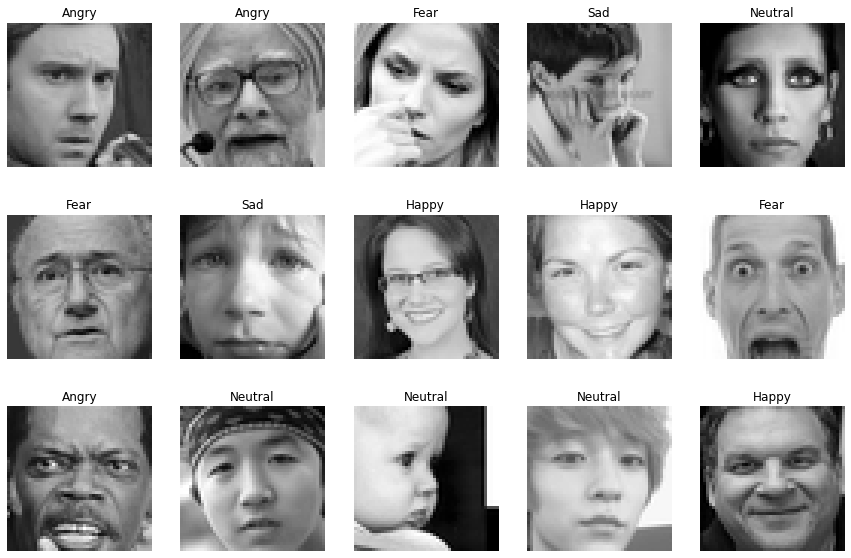

In [11]:
fig = plt.figure(figsize=(15,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(img_array[i], cmap='gray', vmin=0, vmax=255)
    plt.title(emotion_names[data['emotion'][i]])
    plt.axis('off')
    
plt.show()

### Check the ranges of values <a class="anchor" id="P0_check_range"></a>

In [12]:
data.describe() # I usually use includes='all' but its very slow with the pixels arrays

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


### Check the missing values <a class="anchor" id="P0_missing_values"></a>

In [13]:
data.isnull().sum()

emotion    0
pixels     0
usage      0
dtype: int64

> There is no missing values, so we don't need to drop or infer rows

### Check the usage repartition <a class="anchor" id="P0_check_usage"></a>

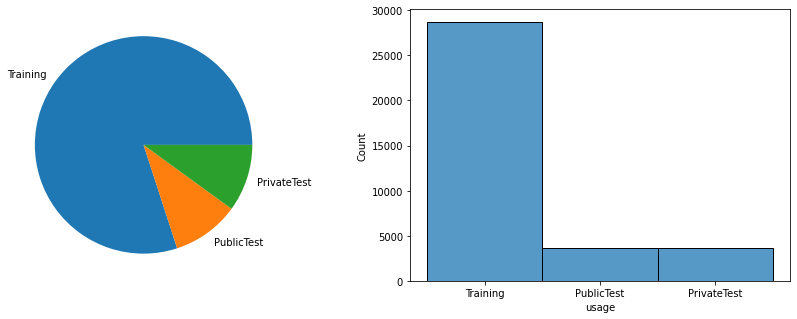

Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64

In [14]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['usage'].value_counts()
plt.pie(list(check), labels=check.keys())

plt.subplot(1,2,2)
sns.histplot(data['usage'])

plt.show()
check

In [15]:
total_size = data['usage'].count()
for i, v in enumerate(data['usage'].unique()):
    set_size = data['usage'].value_counts()[i]
    percent = set_size/(total_size/100.0)
    print(f"{v} has {percent:0.2F}% of the total inputs ({set_size}/{total_size})")

Training has 80.00% of the total inputs (28709/35887)
PublicTest has 10.00% of the total inputs (3589/35887)
PrivateTest has 10.00% of the total inputs (3589/35887)


> The `Training` part can be used as `Training set`
>
> The `PublicTest` part can be used as `Validation set`
>
> The `PrivateTest` part can be used as `Test set`

### Check the target variable <a class="anchor" id="P0_target_variable"></a>

In [16]:
data['emotion'].describe()

count    35887.000000
mean         3.323265
std          1.873819
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max          6.000000
Name: emotion, dtype: float64

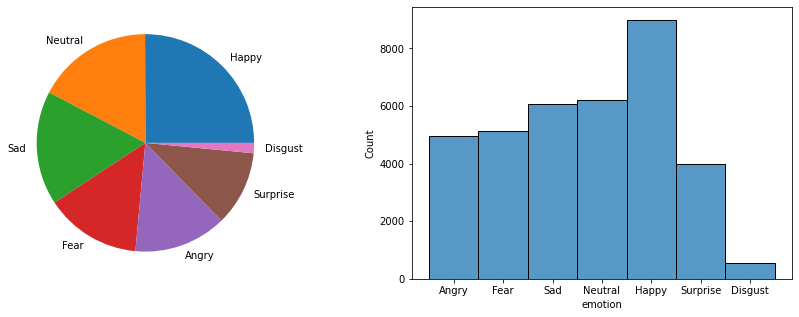

(3) Happy 	=> 8989
(6) Neutral 	=> 6198
(4) Sad 	=> 6077
(2) Fear 	=> 5121
(0) Angry 	=> 4953
(5) Surprise 	=> 4002
(1) Disgust 	=> 547


In [17]:
fig = plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
check = data['emotion'].value_counts()
plt.pie(list(check), labels=check.keys().map(emotion_names))

plt.subplot(1,2,2)
sns.histplot(data['emotion'].map(emotion_names))

plt.show()

for i, n, v in zip(check.keys(),check.keys().map(emotion_names), check.values):
    print(f"({i}) {n} \t=> {v}")

> The `Disgust` value seem under-represented. The dataset is clearly imbalanced.
>
> So we will need to use an appropriate solution *(use upsampling and downsampling techniques)* or metric.<br>
> However there is no longtail to consider as the values are restricted to 10
>
> **/!\ Should we remove this expression** in order to improve the result on the other expressions?

# 2. Feature selection <a class="anchor" id="P02"></a>

> On this project, we don't really feature selection...
>
> There is only two input features, `pixels` and `usage`.
> - The `usage` column will be used to split the dataset, then it will be removed.
> - The `pixels` column will be used to train the CNN

# 3. Split the dataset <a class="anchor" id="P03"></a>

As seen above, the `usage` column can be used to split the dataset instead of using the train_test_split function from sklearn.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train_full, X_test, y_train_full, y_test = train_test_split(img_array, img_labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=42)

In [20]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((21531, 48, 48, 1), (7178, 48, 48, 1), (21531, 7), (7178, 7))

In [21]:
assert(X_valid.shape[0] == X_test.shape[0])

In [22]:
assert(img_array.shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

In [23]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
#num_classes = y_train.shape[1]

In [24]:
img_width, img_height, img_depth#, num_classes

(48, 48, 1)

#### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [25]:
#X_train = X_train / 255.
#X_valid = X_valid / 255.

#### Split between `train`, `valid` and `test` sets

#### Remove `usage` columns

#### Define input sets `X`

#### Define target sets `y`

# 4. Prepare generators

In [26]:
from keras.preprocessing.image import ImageDataGenerator

Define an instance of the ImageDataGenerator that will scale the pixel values to the range of 0-1.

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
#train_datagen.fit(X_train)
train_datagen

In [28]:
valid_datagen = ImageDataGenerator(rescale=1./255) # , preprocessing_function=None
#valid_datagen.fit(X_train)
valid_datagen

In [29]:
img_size=48
batch_size=20
epochs=10

In [30]:
train_ds = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True,
)

In [31]:
valid_ds = valid_datagen.flow( ## train_datagen ?
    x=X_valid,
    y=y_valid,
    batch_size=32,
    shuffle=True,
)

# 5. Try various *classification* models <a class="anchor" id="P04"></a>

## Convolutional Neural Network - Architecture 1

CNN architecture from: https://www.researchgate.net/publication/351056923_Facial_Expression_Recognition_Using_CNN_with_Keras

In [32]:
def architecture1():
    inputs = keras.Input(shape=(48,48,1))
    
    # 1st convolution
    C = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
    B = keras.layers.BatchNormalization()(C)
    A = keras.layers.Activation('relu')(B)
    M = keras.layers.MaxPooling2D((2,2))(A)
    D = keras.layers.Dropout(0.25)(M)
    
    # 2nd convolution
    Con = keras.layers.Conv2D(filters=128, kernel_size=(5,5), padding='same')(D)
    Bat = keras.layers.BatchNormalization()(Con)
    Act = keras.layers.Activation('relu')(Bat)
    Max = keras.layers.MaxPooling2D((2,2))(Act)
    Dro = keras.layers.Dropout(0.25)(Max)
    
    # 3rd convolution
    Con = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = keras.layers.BatchNormalization()(Con)
    Act = keras.layers.Activation('relu')(Bat)
    Max = keras.layers.MaxPooling2D((2,2))(Act)
    Dro = keras.layers.Dropout(0.25)(Max)
    
    # 4rd convolution
    Con = keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same')(Dro)
    Bat = keras.layers.BatchNormalization()(Con)
    Act = keras.layers.Activation('relu')(Bat)
    Max = keras.layers.MaxPooling2D((2,2))(Act)
    Dro = keras.layers.Dropout(0.25)(Max)
    
    # Flatten layer
    Fla = keras.layers.Flatten()(Dro)
    
    # 1st fully connected layer
    Den = keras.layers.Dense(256)(Fla)
    Bat = keras.layers.BatchNormalization()(Den)
    Act = keras.layers.Activation('relu')(Bat)
    Dro = keras.layers.Dropout(0.25)(Act)
    
    # 2nd fully connected layer
    Den = keras.layers.Dense(512)(Dro)
    Bat = keras.layers.BatchNormalization()(Den)
    Act = keras.layers.Activation('relu')(Bat)
    Dro = keras.layers.Dropout(0.25)(Act)
    
    
    # output for the 7 expressions (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).
    outputs = keras.layers.Dense(7, activation='softmax')(Dro)
    
    model = keras.Model(inputs, outputs)
    return model
    

In [33]:
model1 = architecture1()

In [34]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

## Define Optimizer & Loss


In [35]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)

In [36]:
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

## Compile the model

In [37]:
model1.compile(optimizer=f_opti, loss=f_loss, metrics=['accuracy'])

## Fit the model

In [38]:
from tqdm.keras import TqdmCallback

In [39]:
img_size=48
batch_size=20
epochs=100

In [40]:
from keras.callbacks import ModelCheckpoint

In [41]:
filepath = 'model1B.epoch{epoch:02d}-accuracy{val_accuracy:.2f}.hdf5'

In [42]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             #monitor='val_loss',
                             #mode='min'
                             monitor='val_accuracy',
                             mode='max',
                             verbose=1, 
                             save_best_only=True,
                             )

In [43]:
history = model1.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=100,
    validation_data=valid_ds,
    validation_steps=50,
    callbacks=[TqdmCallback(), checkpoint],
    verbose=1,
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 2.0836 - accuracy: 0.2256
Epoch 00001: val_accuracy improved from -inf to 0.25625, saving model to model1B.epoch01-accuracy0.26.hdf5
100/100 [==============================] - 102s 975ms/step - loss: 2.0836 - accuracy: 0.2256 - val_loss: 1.8884 - val_accuracy: 0.2562
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 1.9472 - accuracy: 0.2434
Epoch 00002: val_accuracy improved from 0.25625 to 0.25688, saving model to model1B.epoch02-accuracy0.26.hdf5
100/100 [==============================] - 131s 1s/step - loss: 1.9472 - accuracy: 0.2434 - val_loss: 1.8801 - val_accuracy: 0.2569
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 1.8584 - accuracy: 0.2776
Epoch 00003: val_accuracy improved from 0.25688 to 0.26313, saving model to model1B.epoch03-accuracy0.26.hdf5
100/100 [==============================] - 104s 1s/step - loss: 1.8584 - accuracy: 0.2776 - val_loss: 1.8727 - val_

Epoch 55/100
100/100 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6359
Epoch 00055: val_accuracy did not improve from 0.59062
100/100 [==============================] - 83s 824ms/step - loss: 0.9828 - accuracy: 0.6359 - val_loss: 1.2215 - val_accuracy: 0.5350
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.9728 - accuracy: 0.6275
Epoch 00056: val_accuracy improved from 0.59062 to 0.60000, saving model to model1B.epoch56-accuracy0.60.hdf5
100/100 [==============================] - 133s 1s/step - loss: 0.9728 - accuracy: 0.6275 - val_loss: 1.0709 - val_accuracy: 0.6000
Epoch 57/100
100/100 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.6291
Epoch 00057: val_accuracy did not improve from 0.60000
100/100 [==============================] - 135s 1s/step - loss: 0.9877 - accuracy: 0.6291 - val_loss: 1.1927 - val_accuracy: 0.5431
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.9922 - accurac

In [46]:
model_json = model1.to_json()
with open("model1B.json", "w") as yaml_file:
    yaml_file.write(model_json)
    
model1.save("model1B.h5")

In [47]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

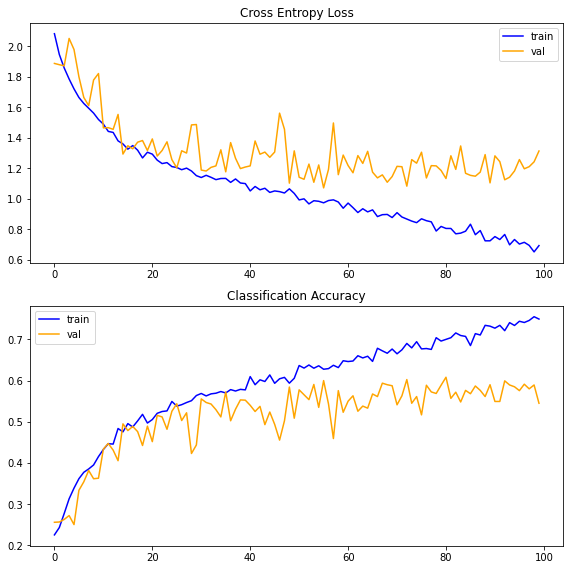

In [48]:
summarize_diagnostics(history)